# Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [25]:
import gym
import numpy as np

In [26]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [27]:
import gym

## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [28]:
env.reset()
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

state, action, reward, done, info: [ 0.04167381  0.14543185 -0.00230572 -0.31454804] 1 1.0 False {}
state, action, reward, done, info: [ 0.04458245 -0.04965718 -0.00859668 -0.02259315] 0 1.0 False {}
state, action, reward, done, info: [ 0.0435893  -0.2446548  -0.00904854  0.26736508] 0 1.0 False {}
state, action, reward, done, info: [ 0.03869621 -0.43964645 -0.00370124  0.55718035] 0 1.0 False {}
state, action, reward, done, info: [ 0.02990328 -0.63471625  0.00744237  0.84869487] 0 1.0 False {}
state, action, reward, done, info: [ 0.01720895 -0.82993891  0.02441626  1.14370879] 0 1.0 False {}
state, action, reward, done, info: [ 6.10174930e-04 -1.02537120e+00  4.72904387e-02  1.44394753e+00] 0 1.0 False {}
state, action, reward, done, info: [-0.01989725 -1.2210422   0.07616939  1.7510241 ] 0 1.0 False {}
state, action, reward, done, info: [-0.04431809 -1.41694169  0.11118987  2.06639347] 0 1.0 False {}
state, action, reward, done, info: [-0.07265693 -1.22311363  0.15251774  1.81006928]

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [29]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [30]:
# Data of the model
def model_input(state_size):
    # Current states and actions for calculating Qs
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    
    # Calculated targetQs
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    
    # returning the given data to the model
    return states, actions, targetQs

In [31]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [32]:
def model_loss(states, actions, targetQs, # model input data for targetQs
               action_size, hidden_size): # model init for Qs
    
    # Calculating action logits: Used to calculate Qs and targetQs
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    
    # # Calculating targetQs using NEW memory using rewards
    # rewarded_actions_logits = np.multiply(actions_logits, rewards.reshape([-1, 1]))
    # Qs = np.max(rewarded_actions_logits, axis=1)
    
    # # Calculating Qs using NEW memory using actions
    # Onehot vectorizing the actions logits
    actions_onehot = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs_onehot = tf.multiply(actions_logits[:-1], actions_onehot[1:])
    Qs = tf.reduce_max(Qs_onehot, axis=1)
    
    # Calculating the loss: logits/predictions vs labels
    loss = tf.reduce_mean(tf.square(Qs - targetQs[1:]))
    #loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs, labels=tf.nn.sigmoid(targetQs[1:])))
    
    return actions_logits, loss

In [33]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [34]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input data

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [35]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [36]:
print('state size:{}'.format(state.shape), 
      'action:{}'.format(action)) #(np.max(action) - np.min(action)+1)

state size:(4,) action:1


In [37]:
# Training parameters
train_episodes = 10000         # max number of episodes to learn from
max_steps = 3000000000         # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation
batch_size = 500               # number of samples in the memory/ experience as mini-batch size

In [38]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [39]:
# Initialize the simulation
env.reset()

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    
    # Take one random step to get the pole and cart moving
    action = env.action_space.sample()
    state, _, done, _ = env.step(action)
    reward = 1 - float(done)
    memory.buffer.append((action, state, reward))
    
    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        # Start new episode
        env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [40]:
state, reward, action

(array([-0.00177195, -0.42283713,  0.00461065,  0.5795461 ]), 1.0, 0)

In [41]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting after training session/graph
rewards_list = [] # accuracy
loss_list = [] # loss

# TF session for training
with tf.Session() as sess:
    
    # Initialize/restore variables
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Explore or exploit parameter
    total_step = 0
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        
        # Start new episode
        env.reset()
        total_reward = 0
        loss_batch = []

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            
            # Batch from the OLD memory
            batch = memory.buffer
            #actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            
            # Calculating next action using OLD memory
            feed_dict={model.states: states}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            last_action_logits = actions_logits[-1]
            
            # Explore (Env) or Exploit (Model)
            # Take new action, get new state and reward
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                action = np.argmax(last_action_logits)
            state, _, done, _ = env.step(action)
            reward = 1 - float(done)
            
            # New memory (time direction)
            memory.buffer.append((action, state, reward))
            
            # Cumulative rewards
            total_reward += reward

            # Batch from NEW memory
            batch = memory.buffer
            actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])

            # Calculating targetQs/nextQs using NEW memory
            feed_dict={model.states: states}
            actions_logits = sess.run(model.actions_logits, feed_dict)            
            rewarded_actions_logits = np.multiply(actions_logits, rewards.reshape([-1, 1]))
            Qs = np.max(rewarded_actions_logits, axis=1)

            # Updating the model using NEW memory and targetQs/nextQs
            feed_dict = {model.states: states, 
                         model.actions: actions, 
                         model.targetQs: Qs} # labelQs
            loss, _ = sess.run([model.loss, model.opt], feed_dict)

            # For average loss in one episode/epoch
            loss_batch.append(loss)

            # At the end of steps/batches loop
            if done is True:
                break
                
        # At the end of each episode/epoch
        print('-------------------------------------------------------------------------------')
        print('Episode: {}'.format(ep),
              'Total reward: {}'.format(total_reward),
              'Average loss: {:.4f}'.format(np.mean(loss_batch)),
              'Explore P: {:.4f}'.format(explore_p))
        print('-------------------------------------------------------------------------------')

        # At the end of each episode/epoch
        # total rewards and losses for plotting
        rewards_list.append((ep, total_reward))
        loss_list.append((ep, np.mean(loss_batch)))
        
    # At the end of all training episodes/epochs
    # Save the trained model
    saver.save(sess, 'checkpoints/model2.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 26.0 Average loss: 0.0134 Explore P: 0.9973
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 40.0 Average loss: 0.0382 Explore P: 0.9933
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 22.0 Average loss: 0.1128 Explore P: 0.9910
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 14.0 Average loss: 0.0997 Explore P: 0.9896
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Epis

-------------------------------------------------------------------------------
Episode: 37 Total reward: 27.0 Average loss: 435.6974 Explore P: 0.9179
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 38 Total reward: 74.0 Average loss: 6477.3237 Explore P: 0.9111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 39 Total reward: 23.0 Average loss: 48306.8438 Explore P: 0.9089
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 40 Total reward: 69.0 Average loss: 257401.9219 Explore P: 0.9027
-------------------------------------------------------------------------------
------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 72 Total reward: 45.0 Average loss: 15287301120.0000 Explore P: 0.8106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 73 Total reward: 40.0 Average loss: 18457120768.0000 Explore P: 0.8074
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 74 Total reward: 18.0 Average loss: 22058506240.0000 Explore P: 0.8058
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 75 Total reward: 45.0 Average loss: 25505767424.0000 Explore P: 0.8022
-------------------------------------------------------------------------------
----------------------------------------

-------------------------------------------------------------------------------
Episode: 107 Total reward: 76.0 Average loss: 1004763807744.0000 Explore P: 0.7182
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 108 Total reward: 56.0 Average loss: 1107688292352.0000 Explore P: 0.7142
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 109 Total reward: 36.0 Average loss: 1445995085824.0000 Explore P: 0.7116
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 110 Total reward: 86.0 Average loss: 1968131932160.0000 Explore P: 0.7055
-------------------------------------------------------------------------------
----------------------------

-------------------------------------------------------------------------------
Episode: 141 Total reward: 46.0 Average loss: 27146584064000.0000 Explore P: 0.5753
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 142 Total reward: 28.0 Average loss: 34538780622848.0000 Explore P: 0.5737
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 143 Total reward: 125.0 Average loss: 34193616666624.0000 Explore P: 0.5666
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 144 Total reward: 68.0 Average loss: 34005516812288.0000 Explore P: 0.5628
-------------------------------------------------------------------------------
-----------------------

-------------------------------------------------------------------------------
Episode: 175 Total reward: 157.0 Average loss: 151960825102336.0000 Explore P: 0.3803
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 176 Total reward: 173.0 Average loss: 167818498670592.0000 Explore P: 0.3739
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 177 Total reward: 197.0 Average loss: 221047622205440.0000 Explore P: 0.3668
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 178 Total reward: 430.0 Average loss: 190298139394048.0000 Explore P: 0.3518
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 211 Total reward: 12.0 Average loss: 5018520035262464.0000 Explore P: 0.2111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 212 Total reward: 9.0 Average loss: 5233055799181312.0000 Explore P: 0.2109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 213 Total reward: 16.0 Average loss: 5516123135016960.0000 Explore P: 0.2105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 214 Total reward: 10.0 Average loss: 5763192739332096.0000 Explore P: 0.2103
-------------------------------------------------------------------------------
-----------------

-------------------------------------------------------------------------------
Episode: 245 Total reward: 127.0 Average loss: 339478610706432.0000 Explore P: 0.1351
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 246 Total reward: 168.0 Average loss: 308145247223808.0000 Explore P: 0.1330
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 247 Total reward: 112.0 Average loss: 279893522776064.0000 Explore P: 0.1316
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 248 Total reward: 181.0 Average loss: 271516642050048.0000 Explore P: 0.1294
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 280 Total reward: 107.0 Average loss: 5938268491218944.0000 Explore P: 0.0701
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 281 Total reward: 112.0 Average loss: 5298183072645120.0000 Explore P: 0.0694
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 282 Total reward: 150.0 Average loss: 4602192749133824.0000 Explore P: 0.0685
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 283 Total reward: 106.0 Average loss: 4644977602723840.0000 Explore P: 0.0679
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 315 Total reward: 17.0 Average loss: 4058295002202112.0000 Explore P: 0.0600
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 316 Total reward: 16.0 Average loss: 4705928020492288.0000 Explore P: 0.0599
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 317 Total reward: 14.0 Average loss: 5386146687221760.0000 Explore P: 0.0598
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 318 Total reward: 19.0 Average loss: 6037590146809856.0000 Explore P: 0.0597
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 349 Total reward: 215.0 Average loss: 45099256847007744.0000 Explore P: 0.0297
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 350 Total reward: 244.0 Average loss: 48188983305306112.0000 Explore P: 0.0292
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 351 Total reward: 251.0 Average loss: 47325828022796288.0000 Explore P: 0.0287
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 352 Total reward: 280.0 Average loss: 45950467825467392.0000 Explore P: 0.0282
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 383 Total reward: 279.0 Average loss: 1120998275416064.0000 Explore P: 0.0164
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 384 Total reward: 452.0 Average loss: 1247408289742848.0000 Explore P: 0.0161
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 385 Total reward: 323.0 Average loss: 4425817769639936.0000 Explore P: 0.0159
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 386 Total reward: 499.0 Average loss: 21558831007924224.0000 Explore P: 0.0157
-------------------------------------------------------------------------------
-----------

-------------------------------------------------------------------------------
Episode: 417 Total reward: 499.0 Average loss: 21291699074498560.0000 Explore P: 0.0116
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 418 Total reward: 388.0 Average loss: 2989107454148608.0000 Explore P: 0.0115
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 419 Total reward: 281.0 Average loss: 23625822673829888.0000 Explore P: 0.0115
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 420 Total reward: 499.0 Average loss: 8733643660853248.0000 Explore P: 0.0114
-------------------------------------------------------------------------------
----------

-------------------------------------------------------------------------------
Episode: 451 Total reward: 499.0 Average loss: 1226948541939712.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 452 Total reward: 457.0 Average loss: 2544397145079808.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 453 Total reward: 346.0 Average loss: 26588377297977344.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 454 Total reward: 304.0 Average loss: 31414410857676800.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
----------

-------------------------------------------------------------------------------
Episode: 485 Total reward: 421.0 Average loss: 26109408987578368.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 486 Total reward: 474.0 Average loss: 24201412716003328.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 487 Total reward: 342.0 Average loss: 1296316558737408.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 488 Total reward: 426.0 Average loss: 3840408626921472.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
----------

-------------------------------------------------------------------------------
Episode: 519 Total reward: 364.0 Average loss: 5170536644608000.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 520 Total reward: 239.0 Average loss: 24168191143968768.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 521 Total reward: 250.0 Average loss: 20781001693200384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 522 Total reward: 408.0 Average loss: 1447998965940224.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------

-------------------------------------------------------------------------------
Episode: 553 Total reward: 433.0 Average loss: 2667808466927616.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 554 Total reward: 481.0 Average loss: 24376619464392704.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 555 Total reward: 469.0 Average loss: 24720423006502912.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 556 Total reward: 499.0 Average loss: 21714532162338816.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 587 Total reward: 499.0 Average loss: 9908308089503744.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 588 Total reward: 393.0 Average loss: 139375958556672.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 589 Total reward: 499.0 Average loss: 878914457042944.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 590 Total reward: 447.0 Average loss: 533869031849984.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
---------------

-------------------------------------------------------------------------------
Episode: 621 Total reward: 312.0 Average loss: 4534287705571328.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 622 Total reward: 380.0 Average loss: 26391835299545088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 623 Total reward: 499.0 Average loss: 24625233646321664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 624 Total reward: 499.0 Average loss: 606927801286656.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----------

-------------------------------------------------------------------------------
Episode: 655 Total reward: 380.0 Average loss: 16517002185146368.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 656 Total reward: 315.0 Average loss: 30189112522702848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 657 Total reward: 453.0 Average loss: 32552145546903552.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 658 Total reward: 295.0 Average loss: 28543283202359296.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 689 Total reward: 499.0 Average loss: 21276112638181376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 690 Total reward: 422.0 Average loss: 2742879394988032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 691 Total reward: 496.0 Average loss: 21264237053607936.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 692 Total reward: 450.0 Average loss: 3391390465654784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------

-------------------------------------------------------------------------------
Episode: 723 Total reward: 370.0 Average loss: 4240147407175680.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 724 Total reward: 499.0 Average loss: 21216294481166336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 725 Total reward: 252.0 Average loss: 253309856251904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 726 Total reward: 499.0 Average loss: 1467525095227392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 757 Total reward: 499.0 Average loss: 345427945717760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 758 Total reward: 351.0 Average loss: 108617474768896.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 759 Total reward: 457.0 Average loss: 922607293562880.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 760 Total reward: 376.0 Average loss: 4004297868050432.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
---------------

-------------------------------------------------------------------------------
Episode: 791 Total reward: 318.0 Average loss: 3946764096765952.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 792 Total reward: 378.0 Average loss: 23600439417110528.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 793 Total reward: 465.0 Average loss: 7152114295898112.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 794 Total reward: 397.0 Average loss: 23505859942285312.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------

-------------------------------------------------------------------------------
Episode: 825 Total reward: 356.0 Average loss: 30188326543687680.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 826 Total reward: 415.0 Average loss: 8988046384955392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 827 Total reward: 379.0 Average loss: 26610964530987008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 828 Total reward: 499.0 Average loss: 27162464101597184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 859 Total reward: 246.0 Average loss: 1646357869756416.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 860 Total reward: 392.0 Average loss: 4333330480758784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 861 Total reward: 482.0 Average loss: 22258792565571584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 862 Total reward: 438.0 Average loss: 1044891924692992.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----------

-------------------------------------------------------------------------------
Episode: 893 Total reward: 397.0 Average loss: 26881180250931200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 894 Total reward: 381.0 Average loss: 29871347219824640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 895 Total reward: 327.0 Average loss: 29050203159920640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 896 Total reward: 499.0 Average loss: 6684356923883520.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 927 Total reward: 477.0 Average loss: 1767635398164480.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 928 Total reward: 499.0 Average loss: 882500083646464.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 929 Total reward: 434.0 Average loss: 3290419005751296.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 930 Total reward: 499.0 Average loss: 21595344672391168.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 961 Total reward: 499.0 Average loss: 26645985694318592.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 962 Total reward: 450.0 Average loss: 2626310224478208.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 963 Total reward: 416.0 Average loss: 26337284919918592.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 964 Total reward: 292.0 Average loss: 27040375361241088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 995 Total reward: 379.0 Average loss: 3009652967079936.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 996 Total reward: 460.0 Average loss: 24756852919107584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 997 Total reward: 364.0 Average loss: 24649845956411392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 998 Total reward: 351.0 Average loss: 10153384292122624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 1028 Total reward: 499.0 Average loss: 2232572855713792.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1029 Total reward: 390.0 Average loss: 84746231087104.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1030 Total reward: 393.0 Average loss: 3836424239448064.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1031 Total reward: 390.0 Average loss: 26402729484091392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 1062 Total reward: 389.0 Average loss: 6861350915538944.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1063 Total reward: 499.0 Average loss: 21810589105913856.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1064 Total reward: 346.0 Average loss: 3350086838910976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1065 Total reward: 499.0 Average loss: 22343525827870720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 1096 Total reward: 452.0 Average loss: 25491786247962624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1097 Total reward: 283.0 Average loss: 25124534331899904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1098 Total reward: 299.0 Average loss: 14104726287155200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1099 Total reward: 461.0 Average loss: 3681225864642560.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 1130 Total reward: 243.0 Average loss: 1006897436033024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1131 Total reward: 439.0 Average loss: 1372799994167296.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1132 Total reward: 499.0 Average loss: 877097752985600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1133 Total reward: 499.0 Average loss: 21644082937856.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----------

-------------------------------------------------------------------------------
Episode: 1164 Total reward: 499.0 Average loss: 12723493795790848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1165 Total reward: 463.0 Average loss: 5864912060416000.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1166 Total reward: 499.0 Average loss: 21382750233690112.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1167 Total reward: 317.0 Average loss: 4396500859748352.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 1197 Total reward: 392.0 Average loss: 3891459950379008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1198 Total reward: 499.0 Average loss: 21552208168353792.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1199 Total reward: 499.0 Average loss: 670142136582144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1200 Total reward: 350.0 Average loss: 9409065385984000.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 1230 Total reward: 439.0 Average loss: 1611214970945536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1231 Total reward: 398.0 Average loss: 3851964773302272.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1232 Total reward: 255.0 Average loss: 23956979684737024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1233 Total reward: 335.0 Average loss: 14592639940689920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 1263 Total reward: 369.0 Average loss: 463847609597952.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1264 Total reward: 370.0 Average loss: 4079541668544512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1265 Total reward: 296.0 Average loss: 23932309392588800.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1266 Total reward: 391.0 Average loss: 10179147653447680.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 1296 Total reward: 395.0 Average loss: 23403794339463168.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1297 Total reward: 401.0 Average loss: 7227976303247360.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1298 Total reward: 499.0 Average loss: 21540111392964608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1299 Total reward: 499.0 Average loss: 30065905631232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 1330 Total reward: 499.0 Average loss: 1814041311838208.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1331 Total reward: 254.0 Average loss: 765225867411456.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1332 Total reward: 381.0 Average loss: 1302526007705600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1333 Total reward: 499.0 Average loss: 1900024275402752.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 1363 Total reward: 496.0 Average loss: 16415042882764800.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1364 Total reward: 325.0 Average loss: 4408189613244416.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1365 Total reward: 319.0 Average loss: 27643732366983168.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1366 Total reward: 499.0 Average loss: 27379864608702464.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 1396 Total reward: 353.0 Average loss: 12449412605280256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1397 Total reward: 426.0 Average loss: 25872258073362432.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1398 Total reward: 288.0 Average loss: 26597087491653632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1399 Total reward: 488.0 Average loss: 8753717801123840.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 1429 Total reward: 396.0 Average loss: 6686847468044288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1430 Total reward: 438.0 Average loss: 26134244635967488.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1431 Total reward: 341.0 Average loss: 25512726361014272.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1432 Total reward: 295.0 Average loss: 13505483860082688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 1462 Total reward: 374.0 Average loss: 1512597287337984.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1463 Total reward: 342.0 Average loss: 4504402786254848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1464 Total reward: 414.0 Average loss: 26305411967614976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1465 Total reward: 499.0 Average loss: 23541890422931456.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 1496 Total reward: 368.0 Average loss: 26793601572798464.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1497 Total reward: 499.0 Average loss: 25143803702673408.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1498 Total reward: 307.0 Average loss: 107286856990720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1499 Total reward: 452.0 Average loss: 3486136370462720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 1530 Total reward: 252.0 Average loss: 6293888025231360.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1531 Total reward: 322.0 Average loss: 4788002698035200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1532 Total reward: 289.0 Average loss: 1440205479346176.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1533 Total reward: 449.0 Average loss: 3820714859692032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 1563 Total reward: 248.0 Average loss: 15936804716806144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1564 Total reward: 234.0 Average loss: 1824133008588800.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1565 Total reward: 419.0 Average loss: 4166248468316160.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1566 Total reward: 499.0 Average loss: 21609150844764160.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 1597 Total reward: 347.0 Average loss: 7738151309148160.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1598 Total reward: 499.0 Average loss: 1173726246731776.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1599 Total reward: 499.0 Average loss: 2678243089973248.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1600 Total reward: 338.0 Average loss: 12098600750284800.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 1630 Total reward: 499.0 Average loss: 1890776137072640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1631 Total reward: 432.0 Average loss: 127865857245184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1632 Total reward: 377.0 Average loss: 3937935791489024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1633 Total reward: 480.0 Average loss: 22038926747238400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 1664 Total reward: 437.0 Average loss: 10124423327645696.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1665 Total reward: 391.0 Average loss: 23804716651642880.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1666 Total reward: 298.0 Average loss: 5993059389014016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1667 Total reward: 342.0 Average loss: 4685850658996224.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 1697 Total reward: 310.0 Average loss: 23798686517559296.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1698 Total reward: 465.0 Average loss: 7907265109557248.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1699 Total reward: 499.0 Average loss: 850888788803584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1700 Total reward: 454.0 Average loss: 2741922154151936.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 1730 Total reward: 499.0 Average loss: 346617181896704.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1731 Total reward: 499.0 Average loss: 129267987906560.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1732 Total reward: 499.0 Average loss: 1529959021543424.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1733 Total reward: 499.0 Average loss: 3509793318764544.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------

-------------------------------------------------------------------------------
Episode: 1763 Total reward: 440.0 Average loss: 28401506331918336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1764 Total reward: 309.0 Average loss: 29316261351522304.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1765 Total reward: 471.0 Average loss: 29356103615643648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1766 Total reward: 491.0 Average loss: 3444447001968640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 1796 Total reward: 499.0 Average loss: 22559545502990336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1797 Total reward: 371.0 Average loss: 15001077371895808.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1798 Total reward: 499.0 Average loss: 23596518111969280.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1799 Total reward: 499.0 Average loss: 3951351658708992.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 1830 Total reward: 392.0 Average loss: 969362039111680.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1831 Total reward: 286.0 Average loss: 1207621054889984.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1832 Total reward: 481.0 Average loss: 3615491121741824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1833 Total reward: 450.0 Average loss: 25591927705436160.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 1864 Total reward: 353.0 Average loss: 4196755084148736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1865 Total reward: 499.0 Average loss: 21391060995407872.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1866 Total reward: 482.0 Average loss: 2475448961335296.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1867 Total reward: 270.0 Average loss: 24034237556457472.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 1897 Total reward: 345.0 Average loss: 6351587689627648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1898 Total reward: 499.0 Average loss: 23556538408894464.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1899 Total reward: 448.0 Average loss: 19482328136941568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1900 Total reward: 305.0 Average loss: 28508826827227136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 1930 Total reward: 499.0 Average loss: 2743517197631488.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1931 Total reward: 499.0 Average loss: 4245077492760576.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1932 Total reward: 453.0 Average loss: 75371147952128.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1933 Total reward: 409.0 Average loss: 3686302247550976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------

-------------------------------------------------------------------------------
Episode: 1964 Total reward: 453.0 Average loss: 22879035235237888.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1965 Total reward: 345.0 Average loss: 5317713362681856.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1966 Total reward: 379.0 Average loss: 23970042827767808.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1967 Total reward: 450.0 Average loss: 7300319658639360.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 1997 Total reward: 462.0 Average loss: 26479785492348928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1998 Total reward: 338.0 Average loss: 24157511707787264.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1999 Total reward: 303.0 Average loss: 13345161320857600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2000 Total reward: 376.0 Average loss: 23815890009063424.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----

-------------------------------------------------------------------------------
Episode: 2030 Total reward: 499.0 Average loss: 2705586999263232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2031 Total reward: 499.0 Average loss: 12538674910593024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2032 Total reward: 499.0 Average loss: 2121535871516672.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2033 Total reward: 343.0 Average loss: 17236206270021632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 2063 Total reward: 429.0 Average loss: 6335587862708224.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2064 Total reward: 259.0 Average loss: 1143338010935296.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2065 Total reward: 423.0 Average loss: 4059390218862592.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2066 Total reward: 497.0 Average loss: 21282690380595200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 2097 Total reward: 289.0 Average loss: 1318609049616384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2098 Total reward: 364.0 Average loss: 4434873439748096.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2099 Total reward: 392.0 Average loss: 23384825616400384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2100 Total reward: 314.0 Average loss: 9146288549396480.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 2130 Total reward: 389.0 Average loss: 11768531439845376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2131 Total reward: 440.0 Average loss: 2628131022176256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2132 Total reward: 264.0 Average loss: 1100189360193536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2133 Total reward: 432.0 Average loss: 3976366085111808.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 2163 Total reward: 499.0 Average loss: 21857266810486784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2164 Total reward: 272.0 Average loss: 7869606299435008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2165 Total reward: 361.0 Average loss: 7855970852012032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2166 Total reward: 499.0 Average loss: 21344890096975872.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 2197 Total reward: 250.0 Average loss: 23902873834225664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2198 Total reward: 289.0 Average loss: 17201505081753600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2199 Total reward: 451.0 Average loss: 3732241486184448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2200 Total reward: 348.0 Average loss: 23389672486993920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 2230 Total reward: 306.0 Average loss: 1348920244436992.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2231 Total reward: 436.0 Average loss: 3853119045763072.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2232 Total reward: 414.0 Average loss: 23100024187518976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2233 Total reward: 362.0 Average loss: 6889578514350080.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 2263 Total reward: 347.0 Average loss: 23641821427007488.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2264 Total reward: 481.0 Average loss: 8379872573390848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2265 Total reward: 403.0 Average loss: 23668783084208128.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2266 Total reward: 392.0 Average loss: 6996526958116864.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 2297 Total reward: 426.0 Average loss: 2915847928545280.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2298 Total reward: 499.0 Average loss: 21122589032185856.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2299 Total reward: 256.0 Average loss: 1438351261433856.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2300 Total reward: 499.0 Average loss: 1436849767710720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 2330 Total reward: 499.0 Average loss: 21412778497540096.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2331 Total reward: 499.0 Average loss: 3128727714136064.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2332 Total reward: 425.0 Average loss: 3309984192397312.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2333 Total reward: 497.0 Average loss: 23754426879574016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 2363 Total reward: 499.0 Average loss: 21305640538341376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2364 Total reward: 447.0 Average loss: 2756221710893056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2365 Total reward: 441.0 Average loss: 3640728081137664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2366 Total reward: 409.0 Average loss: 26253859475161088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 2396 Total reward: 309.0 Average loss: 5092506215645184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2397 Total reward: 499.0 Average loss: 1084440117772288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2398 Total reward: 271.0 Average loss: 274238342692864.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2399 Total reward: 391.0 Average loss: 1028458842947584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 2430 Total reward: 499.0 Average loss: 21574357314699264.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2431 Total reward: 393.0 Average loss: 82151575912448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2432 Total reward: 461.0 Average loss: 932916288815104.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2433 Total reward: 350.0 Average loss: 1004113693245440.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------

-------------------------------------------------------------------------------
Episode: 2463 Total reward: 499.0 Average loss: 4827014959726592.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2464 Total reward: 405.0 Average loss: 77879543070720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2465 Total reward: 458.0 Average loss: 913210374881280.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2466 Total reward: 371.0 Average loss: 999906974105600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 2497 Total reward: 422.0 Average loss: 4771714034565120.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2498 Total reward: 493.0 Average loss: 959966395498496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2499 Total reward: 329.0 Average loss: 983114591502336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2500 Total reward: 417.0 Average loss: 3916056959647744.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------

-------------------------------------------------------------------------------
Episode: 2531 Total reward: 449.0 Average loss: 7744194328133632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2532 Total reward: 365.0 Average loss: 23355117327613952.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2533 Total reward: 420.0 Average loss: 5753805551435776.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2534 Total reward: 499.0 Average loss: 2147430363561984.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 2564 Total reward: 482.0 Average loss: 24536269841235968.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2565 Total reward: 327.0 Average loss: 23538875355889664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2566 Total reward: 274.0 Average loss: 11462254100742144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2567 Total reward: 499.0 Average loss: 1201426235654144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 2597 Total reward: 353.0 Average loss: 3449535732908032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2598 Total reward: 364.0 Average loss: 23543571902627840.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2599 Total reward: 310.0 Average loss: 11220024387698688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2600 Total reward: 372.0 Average loss: 23751396780146688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 2630 Total reward: 368.0 Average loss: 3372986530791424.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2631 Total reward: 475.0 Average loss: 1094788036165632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2632 Total reward: 306.0 Average loss: 996971565285376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2633 Total reward: 499.0 Average loss: 3418498957049856.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 2663 Total reward: 434.0 Average loss: 28051595346313216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2664 Total reward: 408.0 Average loss: 24943540115079168.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2665 Total reward: 428.0 Average loss: 6251447842766848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2666 Total reward: 444.0 Average loss: 25586909036150784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 2697 Total reward: 441.0 Average loss: 8747137911226368.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2698 Total reward: 499.0 Average loss: 884178878988288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2699 Total reward: 499.0 Average loss: 1134302741921792.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2700 Total reward: 311.0 Average loss: 13601064062287872.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 2730 Total reward: 376.0 Average loss: 26651927781572608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2731 Total reward: 499.0 Average loss: 26297745450991616.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2732 Total reward: 499.0 Average loss: 14387455394316288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2733 Total reward: 427.0 Average loss: 12274419531513856.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----

-------------------------------------------------------------------------------
Episode: 2763 Total reward: 322.0 Average loss: 4501170823364608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2764 Total reward: 472.0 Average loss: 25193210858962944.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2765 Total reward: 428.0 Average loss: 25646254746763264.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2766 Total reward: 389.0 Average loss: 28277796241408000.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 2796 Total reward: 308.0 Average loss: 3722064829612032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2797 Total reward: 482.0 Average loss: 24044547625451520.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2798 Total reward: 499.0 Average loss: 21454890651877376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2799 Total reward: 499.0 Average loss: 607223080288256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 2829 Total reward: 391.0 Average loss: 26458100202471424.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2830 Total reward: 499.0 Average loss: 24524495188393984.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2831 Total reward: 407.0 Average loss: 5406129022566400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2832 Total reward: 499.0 Average loss: 21395879948713984.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 2862 Total reward: 448.0 Average loss: 25122489927467008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2863 Total reward: 499.0 Average loss: 22005767452229632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2864 Total reward: 268.0 Average loss: 122011766489088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2865 Total reward: 442.0 Average loss: 3507186542051328.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 2896 Total reward: 246.0 Average loss: 23814483407273984.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2897 Total reward: 437.0 Average loss: 11931934544363520.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2898 Total reward: 499.0 Average loss: 872165721243648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2899 Total reward: 436.0 Average loss: 2742116769857536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 2929 Total reward: 296.0 Average loss: 111179447926784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2930 Total reward: 265.0 Average loss: 1005429362524160.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2931 Total reward: 499.0 Average loss: 1165656674271232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2932 Total reward: 394.0 Average loss: 79771149008896.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----------

-------------------------------------------------------------------------------
Episode: 2963 Total reward: 435.0 Average loss: 2952982752657408.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2964 Total reward: 344.0 Average loss: 23397227334467584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2965 Total reward: 393.0 Average loss: 10077553423286272.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2966 Total reward: 322.0 Average loss: 27080823215751168.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 2997 Total reward: 356.0 Average loss: 1361840445587456.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2998 Total reward: 413.0 Average loss: 3953887031590912.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2999 Total reward: 458.0 Average loss: 22970404222009344.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3000 Total reward: 407.0 Average loss: 4436393052864512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 3031 Total reward: 499.0 Average loss: 21653943058694144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3032 Total reward: 258.0 Average loss: 1083119012675584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3033 Total reward: 499.0 Average loss: 1522436923195392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3034 Total reward: 262.0 Average loss: 3814162350211072.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 3064 Total reward: 466.0 Average loss: 1287394972139520.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3065 Total reward: 486.0 Average loss: 3221979507195904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3066 Total reward: 479.0 Average loss: 24539993577881600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3067 Total reward: 438.0 Average loss: 25813406283988992.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 3097 Total reward: 338.0 Average loss: 31076420553801728.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3098 Total reward: 313.0 Average loss: 32199492224679936.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3099 Total reward: 422.0 Average loss: 8595094995206144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3100 Total reward: 499.0 Average loss: 1371608274960384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 3130 Total reward: 270.0 Average loss: 3664275239337984.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3131 Total reward: 499.0 Average loss: 1167549412671488.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3132 Total reward: 318.0 Average loss: 3596941694861312.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3133 Total reward: 243.0 Average loss: 23582065547018240.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 3163 Total reward: 425.0 Average loss: 24634495743295488.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3164 Total reward: 432.0 Average loss: 2812011188584448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3165 Total reward: 499.0 Average loss: 2367858419957760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3166 Total reward: 499.0 Average loss: 14979061369536512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 3196 Total reward: 325.0 Average loss: 3253154795749376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3197 Total reward: 367.0 Average loss: 4338972725608448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3198 Total reward: 435.0 Average loss: 25886875994554368.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3199 Total reward: 499.0 Average loss: 23529011963494400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 3230 Total reward: 499.0 Average loss: 3117214248992768.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3231 Total reward: 301.0 Average loss: 19491418435223552.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3232 Total reward: 486.0 Average loss: 9104202164862976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3233 Total reward: 499.0 Average loss: 22045229611745280.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 3264 Total reward: 499.0 Average loss: 1179505259446272.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3265 Total reward: 499.0 Average loss: 75133230252032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3266 Total reward: 402.0 Average loss: 3736036895096832.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3267 Total reward: 390.0 Average loss: 23519004689694720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 3298 Total reward: 269.0 Average loss: 23683418185269248.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3299 Total reward: 265.0 Average loss: 16939157741895680.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3300 Total reward: 297.0 Average loss: 1586976457228288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3301 Total reward: 336.0 Average loss: 1423563286380544.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 3331 Total reward: 437.0 Average loss: 8980166193709056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3332 Total reward: 499.0 Average loss: 22577719657103360.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3333 Total reward: 445.0 Average loss: 9787899755102208.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3334 Total reward: 385.0 Average loss: 1443211285364736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 3365 Total reward: 445.0 Average loss: 22988224041320448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3366 Total reward: 439.0 Average loss: 2023299097821184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3367 Total reward: 390.0 Average loss: 3923550335401984.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3368 Total reward: 499.0 Average loss: 22516331689541632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 3399 Total reward: 499.0 Average loss: 23645762059501568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3400 Total reward: 413.0 Average loss: 2857586160304128.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3401 Total reward: 400.0 Average loss: 23349881762480128.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3402 Total reward: 241.0 Average loss: 6366515922206720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 3432 Total reward: 379.0 Average loss: 26382240342605824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3433 Total reward: 499.0 Average loss: 24960597577695232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3434 Total reward: 290.0 Average loss: 332518012223488.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3435 Total reward: 499.0 Average loss: 891684401446912.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 3466 Total reward: 306.0 Average loss: 27948043684806656.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3467 Total reward: 292.0 Average loss: 35065017095159808.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3468 Total reward: 301.0 Average loss: 13203918100103168.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3469 Total reward: 499.0 Average loss: 1096203362107392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 3499 Total reward: 499.0 Average loss: 3327659324997632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3500 Total reward: 251.0 Average loss: 971209613246464.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3501 Total reward: 290.0 Average loss: 1582105830096896.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3502 Total reward: 256.0 Average loss: 1598514081562624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 3533 Total reward: 494.0 Average loss: 3515611925708800.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3534 Total reward: 480.0 Average loss: 24412256955531264.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3535 Total reward: 297.0 Average loss: 23995469034160128.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3536 Total reward: 479.0 Average loss: 8431644646047744.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 3567 Total reward: 282.0 Average loss: 6398813539401728.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3568 Total reward: 428.0 Average loss: 3972282108084224.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3569 Total reward: 499.0 Average loss: 23264192869957632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3570 Total reward: 499.0 Average loss: 17566549384626176.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 3601 Total reward: 270.0 Average loss: 24640790017867776.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3602 Total reward: 319.0 Average loss: 18050188471959552.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3603 Total reward: 399.0 Average loss: 26693578226925568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3604 Total reward: 499.0 Average loss: 23922519014637568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----

-------------------------------------------------------------------------------
Episode: 3634 Total reward: 375.0 Average loss: 26463726609629184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3635 Total reward: 383.0 Average loss: 31243593565863936.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3636 Total reward: 317.0 Average loss: 32282823180156928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3637 Total reward: 499.0 Average loss: 27572743000031232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----

-------------------------------------------------------------------------------
Episode: 3667 Total reward: 247.0 Average loss: 18366111233867776.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3668 Total reward: 497.0 Average loss: 8232844031688704.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3669 Total reward: 339.0 Average loss: 4235560650539008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3670 Total reward: 378.0 Average loss: 26477747530366976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 3700 Total reward: 311.0 Average loss: 700050476892160.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3701 Total reward: 499.0 Average loss: 2293248395575296.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3702 Total reward: 484.0 Average loss: 14160069088247808.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3703 Total reward: 262.0 Average loss: 23849998491844608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 3734 Total reward: 267.0 Average loss: 36104014781218816.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3735 Total reward: 499.0 Average loss: 9752616598765568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3736 Total reward: 499.0 Average loss: 2490029033127936.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3737 Total reward: 472.0 Average loss: 4638381606699008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 3768 Total reward: 289.0 Average loss: 23728734385209344.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3769 Total reward: 499.0 Average loss: 8392438573957120.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3770 Total reward: 482.0 Average loss: 2429872110567424.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3771 Total reward: 239.0 Average loss: 23851349259059200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 3801 Total reward: 499.0 Average loss: 64419505635328.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3802 Total reward: 362.0 Average loss: 3562314057908224.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3803 Total reward: 309.0 Average loss: 24025100013535232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3804 Total reward: 282.0 Average loss: 12850105136709632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 3834 Total reward: 346.0 Average loss: 3776050152603648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3835 Total reward: 363.0 Average loss: 5205400504762368.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3836 Total reward: 287.0 Average loss: 28059942615252992.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3837 Total reward: 485.0 Average loss: 32101775276244992.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 3867 Total reward: 449.0 Average loss: 26937809394728960.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3868 Total reward: 344.0 Average loss: 25080624733749248.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3869 Total reward: 499.0 Average loss: 6107899298316288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3870 Total reward: 315.0 Average loss: 2771211952062464.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 3900 Total reward: 416.0 Average loss: 12146288845914112.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3901 Total reward: 499.0 Average loss: 22481688483332096.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3902 Total reward: 464.0 Average loss: 5491875897147392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3903 Total reward: 465.0 Average loss: 24713935458402304.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 3933 Total reward: 499.0 Average loss: 11434137097338880.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3934 Total reward: 337.0 Average loss: 277520352018432.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3935 Total reward: 499.0 Average loss: 1642360731598848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3936 Total reward: 499.0 Average loss: 7205395512688640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 3967 Total reward: 426.0 Average loss: 18944001231028224.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3968 Total reward: 499.0 Average loss: 2087506711412736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3969 Total reward: 369.0 Average loss: 3128504375836672.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3970 Total reward: 499.0 Average loss: 21566409477718016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 4001 Total reward: 389.0 Average loss: 1278372856463360.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4002 Total reward: 342.0 Average loss: 4435593383641088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4003 Total reward: 477.0 Average loss: 22205796964106240.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4004 Total reward: 445.0 Average loss: 3697463793811456.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 4034 Total reward: 428.0 Average loss: 2849778178195456.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4035 Total reward: 272.0 Average loss: 23896386286125056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4036 Total reward: 363.0 Average loss: 12541947675672576.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4037 Total reward: 401.0 Average loss: 3930998882435072.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 4067 Total reward: 373.0 Average loss: 32393519519760384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4068 Total reward: 444.0 Average loss: 30050428028715008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4069 Total reward: 499.0 Average loss: 22930598465110016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4070 Total reward: 404.0 Average loss: 8436226839281664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 4100 Total reward: 499.0 Average loss: 24544999362265088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4101 Total reward: 475.0 Average loss: 3421054462590976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4102 Total reward: 499.0 Average loss: 21369534619320320.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4103 Total reward: 310.0 Average loss: 1541241095323648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 4133 Total reward: 499.0 Average loss: 10715911191265280.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4134 Total reward: 283.0 Average loss: 131378301632512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4135 Total reward: 499.0 Average loss: 853662062608384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4136 Total reward: 499.0 Average loss: 501386294853632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------

-------------------------------------------------------------------------------
Episode: 4167 Total reward: 371.0 Average loss: 4389163176558592.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4168 Total reward: 453.0 Average loss: 23054652153004032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4169 Total reward: 459.0 Average loss: 4225885162962944.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4170 Total reward: 315.0 Average loss: 24068657424367616.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 4201 Total reward: 499.0 Average loss: 1905587466010624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4202 Total reward: 328.0 Average loss: 20733407013109760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4203 Total reward: 333.0 Average loss: 29888449779597312.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4204 Total reward: 258.0 Average loss: 11630957194903552.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 4234 Total reward: 378.0 Average loss: 26813663365038080.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4235 Total reward: 470.0 Average loss: 28666789281923072.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4236 Total reward: 499.0 Average loss: 21807281981095936.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4237 Total reward: 488.0 Average loss: 356686128742400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 4268 Total reward: 499.0 Average loss: 48061355130880.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4269 Total reward: 499.0 Average loss: 649214975541248.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4270 Total reward: 499.0 Average loss: 550177626652672.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4271 Total reward: 447.0 Average loss: 2861601954725888.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 4302 Total reward: 499.0 Average loss: 21536048353902592.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4303 Total reward: 470.0 Average loss: 2157345161347072.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4304 Total reward: 397.0 Average loss: 3830145534132224.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4305 Total reward: 412.0 Average loss: 26310593845657600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 4335 Total reward: 379.0 Average loss: 10067352875958272.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4336 Total reward: 248.0 Average loss: 24109171850870784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4337 Total reward: 466.0 Average loss: 13557364917534720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4338 Total reward: 499.0 Average loss: 21479694088011776.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----

-------------------------------------------------------------------------------
Episode: 4368 Total reward: 424.0 Average loss: 13052883427655680.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4369 Total reward: 499.0 Average loss: 21698593538703360.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4370 Total reward: 352.0 Average loss: 4665484997820416.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4371 Total reward: 272.0 Average loss: 24202484310343680.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 4401 Total reward: 481.0 Average loss: 1089021304373248.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4402 Total reward: 499.0 Average loss: 841383489306624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4403 Total reward: 381.0 Average loss: 335734338748416.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4404 Total reward: 350.0 Average loss: 4223456090521600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------

-------------------------------------------------------------------------------
Episode: 4435 Total reward: 402.0 Average loss: 24777415075037184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4436 Total reward: 355.0 Average loss: 7725827974234112.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4437 Total reward: 263.0 Average loss: 24324066244558848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4438 Total reward: 499.0 Average loss: 9665651027214336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 4469 Total reward: 384.0 Average loss: 27765385168158720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4470 Total reward: 498.0 Average loss: 27249022724997120.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4471 Total reward: 499.0 Average loss: 22634129757569024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4472 Total reward: 346.0 Average loss: 14121739726356480.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----

-------------------------------------------------------------------------------
Episode: 4503 Total reward: 499.0 Average loss: 18135432298496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4504 Total reward: 345.0 Average loss: 231275147296768.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4505 Total reward: 499.0 Average loss: 859552677363712.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4506 Total reward: 482.0 Average loss: 2412698952269824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 4536 Total reward: 418.0 Average loss: 26184420591403008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4537 Total reward: 453.0 Average loss: 27322157428113408.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4538 Total reward: 499.0 Average loss: 23366883390521344.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4539 Total reward: 370.0 Average loss: 17556264011694080.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----

-------------------------------------------------------------------------------
Episode: 4569 Total reward: 369.0 Average loss: 430092555649024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4570 Total reward: 450.0 Average loss: 3467267505389568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4571 Total reward: 390.0 Average loss: 23279218813042688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4572 Total reward: 293.0 Average loss: 6065067200086016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 4603 Total reward: 499.0 Average loss: 996956868444160.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4604 Total reward: 329.0 Average loss: 3586159984771072.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4605 Total reward: 425.0 Average loss: 23105440141279232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4606 Total reward: 402.0 Average loss: 5746202385580032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 4637 Total reward: 312.0 Average loss: 4249457017225216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4638 Total reward: 431.0 Average loss: 23535426497150976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4639 Total reward: 387.0 Average loss: 5730382410416128.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4640 Total reward: 244.0 Average loss: 23953099181785088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 4670 Total reward: 499.0 Average loss: 22811391647809536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4671 Total reward: 357.0 Average loss: 88891855994880.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4672 Total reward: 482.0 Average loss: 3190828646268928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4673 Total reward: 267.0 Average loss: 23374985846325248.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 4704 Total reward: 269.0 Average loss: 24091090038554624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4705 Total reward: 247.0 Average loss: 18099492549033984.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4706 Total reward: 391.0 Average loss: 4297285504598016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4707 Total reward: 398.0 Average loss: 23444594381291520.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 4737 Total reward: 461.0 Average loss: 24882978928721920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4738 Total reward: 335.0 Average loss: 27818836036157440.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4739 Total reward: 373.0 Average loss: 33998175136120832.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4740 Total reward: 327.0 Average loss: 32773873233559552.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----

-------------------------------------------------------------------------------
Episode: 4770 Total reward: 433.0 Average loss: 23873818380468224.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4771 Total reward: 267.0 Average loss: 3554875442987008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4772 Total reward: 499.0 Average loss: 1737574116753408.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4773 Total reward: 306.0 Average loss: 6141221265211392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 4803 Total reward: 370.0 Average loss: 3651700648837120.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4804 Total reward: 425.0 Average loss: 23144975315238912.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4805 Total reward: 304.0 Average loss: 3654306620243968.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4806 Total reward: 499.0 Average loss: 1332061826711552.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 4836 Total reward: 499.0 Average loss: 5596657529913344.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4837 Total reward: 404.0 Average loss: 3021712429940736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4838 Total reward: 460.0 Average loss: 25298617946341376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4839 Total reward: 284.0 Average loss: 24539821779189760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 4870 Total reward: 388.0 Average loss: 1444038469222400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4871 Total reward: 499.0 Average loss: 1796459863212032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4872 Total reward: 445.0 Average loss: 8461116711632896.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4873 Total reward: 409.0 Average loss: 4066858093248512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 4903 Total reward: 466.0 Average loss: 26429882267336704.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4904 Total reward: 475.0 Average loss: 1314999800692736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4905 Total reward: 303.0 Average loss: 996705344421888.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4906 Total reward: 443.0 Average loss: 3725456243163136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 4937 Total reward: 453.0 Average loss: 426109745233920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4938 Total reward: 436.0 Average loss: 961369306300416.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4939 Total reward: 456.0 Average loss: 3461369978421248.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4940 Total reward: 409.0 Average loss: 25829705684877312.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 4970 Total reward: 482.0 Average loss: 6778960557899776.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4971 Total reward: 404.0 Average loss: 23360007147880448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4972 Total reward: 495.0 Average loss: 3342662451068928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4973 Total reward: 247.0 Average loss: 1011929527091200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 5003 Total reward: 364.0 Average loss: 14607779700408320.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5004 Total reward: 499.0 Average loss: 24095361383530496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5005 Total reward: 477.0 Average loss: 7149587244515328.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5006 Total reward: 475.0 Average loss: 3401832604893184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 5036 Total reward: 238.0 Average loss: 1744760133910528.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5037 Total reward: 468.0 Average loss: 1344033242742784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5038 Total reward: 369.0 Average loss: 4062038334636032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5039 Total reward: 499.0 Average loss: 21486014132387840.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 5070 Total reward: 358.0 Average loss: 3427167274795008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5071 Total reward: 447.0 Average loss: 25193137844518912.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5072 Total reward: 422.0 Average loss: 24559561448882176.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5073 Total reward: 499.0 Average loss: 2610758953205760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 5103 Total reward: 499.0 Average loss: 1064323027828736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5104 Total reward: 408.0 Average loss: 3258001129472000.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5105 Total reward: 260.0 Average loss: 23961826555330560.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5106 Total reward: 470.0 Average loss: 12870935728095232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 5137 Total reward: 313.0 Average loss: 15973232481927168.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5138 Total reward: 248.0 Average loss: 1517474759573504.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5139 Total reward: 435.0 Average loss: 3960421555896320.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5140 Total reward: 494.0 Average loss: 24007389715890176.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 5170 Total reward: 423.0 Average loss: 25938282458120192.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5171 Total reward: 499.0 Average loss: 22903452124315648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5172 Total reward: 499.0 Average loss: 2364410167296.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5173 Total reward: 480.0 Average loss: 85536798670848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----------

-------------------------------------------------------------------------------
Episode: 5204 Total reward: 499.0 Average loss: 925011737051136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5205 Total reward: 499.0 Average loss: 21433931530240.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5206 Total reward: 290.0 Average loss: 265305884459008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5207 Total reward: 499.0 Average loss: 887747258613760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------

-------------------------------------------------------------------------------
Episode: 5237 Total reward: 418.0 Average loss: 3506287551709184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5238 Total reward: 470.0 Average loss: 24985317261967360.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5239 Total reward: 452.0 Average loss: 25732547082190848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5240 Total reward: 396.0 Average loss: 24436366754447360.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 5271 Total reward: 400.0 Average loss: 15228995180167168.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5272 Total reward: 368.0 Average loss: 23676941374586880.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5273 Total reward: 367.0 Average loss: 9369225269346304.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5274 Total reward: 499.0 Average loss: 21334973017489408.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 5304 Total reward: 499.0 Average loss: 6233698890416128.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5305 Total reward: 499.0 Average loss: 190997380202496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5306 Total reward: 462.0 Average loss: 2499858065784832.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5307 Total reward: 242.0 Average loss: 23537118714265600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 5337 Total reward: 494.0 Average loss: 25382631801618432.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5338 Total reward: 243.0 Average loss: 23756142719008768.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5339 Total reward: 402.0 Average loss: 15842276781588480.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5340 Total reward: 257.0 Average loss: 24240331562156032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----

-------------------------------------------------------------------------------
Episode: 5370 Total reward: 499.0 Average loss: 4588893382901760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5371 Total reward: 483.0 Average loss: 394588208496640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5372 Total reward: 499.0 Average loss: 1288854455713792.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5373 Total reward: 427.0 Average loss: 5049435209859072.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 5404 Total reward: 277.0 Average loss: 1426525874290688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5405 Total reward: 499.0 Average loss: 1161116356968448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5406 Total reward: 425.0 Average loss: 97846317547520.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5407 Total reward: 420.0 Average loss: 3676650382295040.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------

-------------------------------------------------------------------------------
Episode: 5437 Total reward: 499.0 Average loss: 1970142971953152.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5438 Total reward: 274.0 Average loss: 17900824541790208.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5439 Total reward: 499.0 Average loss: 7018548329185280.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5440 Total reward: 435.0 Average loss: 81248215105536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 5470 Total reward: 499.0 Average loss: 21542005473542144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5471 Total reward: 427.0 Average loss: 75768692473856.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5472 Total reward: 439.0 Average loss: 3533128681390080.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5473 Total reward: 413.0 Average loss: 23437709548716032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 5504 Total reward: 499.0 Average loss: 2341160903245824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5505 Total reward: 499.0 Average loss: 13385776679092224.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5506 Total reward: 353.0 Average loss: 249189388779520.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5507 Total reward: 438.0 Average loss: 967426082603008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 5538 Total reward: 413.0 Average loss: 113473556054016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5539 Total reward: 406.0 Average loss: 3753301858320384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5540 Total reward: 499.0 Average loss: 22178944828571648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5541 Total reward: 499.0 Average loss: 6838280498708480.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 5572 Total reward: 499.0 Average loss: 21674651243511808.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5573 Total reward: 487.0 Average loss: 2456900608196608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5574 Total reward: 390.0 Average loss: 26164090363707392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5575 Total reward: 496.0 Average loss: 26725580028248064.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 5605 Total reward: 499.0 Average loss: 2094479456600064.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5606 Total reward: 499.0 Average loss: 1541457588518912.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5607 Total reward: 395.0 Average loss: 130360587321344.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5608 Total reward: 319.0 Average loss: 986287028830208.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------

-------------------------------------------------------------------------------
Episode: 5639 Total reward: 345.0 Average loss: 27321180323053568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5640 Total reward: 406.0 Average loss: 29519894340960256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5641 Total reward: 498.0 Average loss: 3244647270842368.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5642 Total reward: 389.0 Average loss: 954973630234624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 5672 Total reward: 274.0 Average loss: 1141021681385472.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5673 Total reward: 347.0 Average loss: 4675746748432384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5674 Total reward: 499.0 Average loss: 22966366952751104.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5675 Total reward: 499.0 Average loss: 11175263312281600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 5706 Total reward: 499.0 Average loss: 19538040305221632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5707 Total reward: 486.0 Average loss: 156128621101056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5708 Total reward: 392.0 Average loss: 3817645300252672.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5709 Total reward: 286.0 Average loss: 27618548826243072.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 5740 Total reward: 499.0 Average loss: 21287090574589952.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5741 Total reward: 447.0 Average loss: 2644812943589376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5742 Total reward: 499.0 Average loss: 21817800356003840.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5743 Total reward: 499.0 Average loss: 5888181656354816.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 5774 Total reward: 499.0 Average loss: 26716053790785536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5775 Total reward: 468.0 Average loss: 2720105062465536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5776 Total reward: 499.0 Average loss: 21094729726820352.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5777 Total reward: 380.0 Average loss: 903383691034624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 5807 Total reward: 499.0 Average loss: 27163900768157696.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5808 Total reward: 326.0 Average loss: 7162758298599424.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5809 Total reward: 449.0 Average loss: 23727089412734976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5810 Total reward: 278.0 Average loss: 2490236265299968.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 5840 Total reward: 458.0 Average loss: 7377937770741760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5841 Total reward: 431.0 Average loss: 25702269710237696.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5842 Total reward: 499.0 Average loss: 23492975040397312.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5843 Total reward: 499.0 Average loss: 8287401927507968.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 5873 Total reward: 438.0 Average loss: 7165065769779200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5874 Total reward: 397.0 Average loss: 4270427463483392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5875 Total reward: 499.0 Average loss: 22035520838172672.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5876 Total reward: 499.0 Average loss: 5433240466751488.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 5906 Total reward: 396.0 Average loss: 12972837048418304.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5907 Total reward: 499.0 Average loss: 22437205507047424.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5908 Total reward: 355.0 Average loss: 4138230517596160.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5909 Total reward: 499.0 Average loss: 21750891207983104.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 5940 Total reward: 284.0 Average loss: 19407185536614400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5941 Total reward: 432.0 Average loss: 3988286766841856.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5942 Total reward: 288.0 Average loss: 24189863548944384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5943 Total reward: 438.0 Average loss: 12339511908368384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 5973 Total reward: 350.0 Average loss: 15401332890402816.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5974 Total reward: 388.0 Average loss: 26530775344087040.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5975 Total reward: 499.0 Average loss: 24687252974075904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5976 Total reward: 499.0 Average loss: 1061643773542400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 6006 Total reward: 438.0 Average loss: 14319543371431936.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6007 Total reward: 365.0 Average loss: 1933231888793600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6008 Total reward: 411.0 Average loss: 1164590448640000.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6009 Total reward: 405.0 Average loss: 1081277612556288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 6039 Total reward: 313.0 Average loss: 27510989960249344.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6040 Total reward: 499.0 Average loss: 27578923457970176.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6041 Total reward: 499.0 Average loss: 77154297577472.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6042 Total reward: 343.0 Average loss: 105092179034112.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 6072 Total reward: 499.0 Average loss: 21995216865067008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6073 Total reward: 255.0 Average loss: 8741147505590272.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6074 Total reward: 330.0 Average loss: 9442934424338432.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6075 Total reward: 271.0 Average loss: 23973253315821568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 6106 Total reward: 348.0 Average loss: 28608467921010688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6107 Total reward: 499.0 Average loss: 25835707901673472.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6108 Total reward: 489.0 Average loss: 137054738448384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6109 Total reward: 499.0 Average loss: 811489778728960.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 6139 Total reward: 348.0 Average loss: 27121625405063168.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6140 Total reward: 499.0 Average loss: 26409335143792640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6141 Total reward: 476.0 Average loss: 3008191872892928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6142 Total reward: 452.0 Average loss: 22678994985943040.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 6172 Total reward: 499.0 Average loss: 16278284681609216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6173 Total reward: 499.0 Average loss: 172907514822656.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6174 Total reward: 444.0 Average loss: 2899884340412416.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6175 Total reward: 306.0 Average loss: 23880960911081472.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 6206 Total reward: 370.0 Average loss: 4183038032347136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6207 Total reward: 499.0 Average loss: 21503904818659328.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6208 Total reward: 499.0 Average loss: 52736674496512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6209 Total reward: 499.0 Average loss: 1138406180519936.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 6239 Total reward: 360.0 Average loss: 17521024878772224.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6240 Total reward: 267.0 Average loss: 23907293355573248.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6241 Total reward: 442.0 Average loss: 13150560647643136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6242 Total reward: 243.0 Average loss: 23798411639652352.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----

-------------------------------------------------------------------------------
Episode: 6273 Total reward: 294.0 Average loss: 6807658992500736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6274 Total reward: 365.0 Average loss: 6920772324950016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6275 Total reward: 467.0 Average loss: 25131784236695552.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6276 Total reward: 364.0 Average loss: 24197882252886016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 6306 Total reward: 338.0 Average loss: 3679925563293696.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6307 Total reward: 499.0 Average loss: 21402674586976256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6308 Total reward: 387.0 Average loss: 903930829602816.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6309 Total reward: 448.0 Average loss: 3554855847198720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 6340 Total reward: 498.0 Average loss: 889513161261056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6341 Total reward: 334.0 Average loss: 4328663193485312.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6342 Total reward: 240.0 Average loss: 24241130426073088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6343 Total reward: 377.0 Average loss: 17031555373334528.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 6374 Total reward: 499.0 Average loss: 186676945092608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6375 Total reward: 442.0 Average loss: 2616364153962496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6376 Total reward: 499.0 Average loss: 21032794150928384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6377 Total reward: 349.0 Average loss: 3656046081998848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 6407 Total reward: 426.0 Average loss: 4125588012924928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6408 Total reward: 375.0 Average loss: 23568987371601920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6409 Total reward: 384.0 Average loss: 5686728899690496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6410 Total reward: 481.0 Average loss: 3285271755882496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 6441 Total reward: 322.0 Average loss: 23978836773306368.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6442 Total reward: 254.0 Average loss: 12944625555734528.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6443 Total reward: 499.0 Average loss: 1200814337032192.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6444 Total reward: 499.0 Average loss: 399335153991680.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 6475 Total reward: 316.0 Average loss: 4720024640028672.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6476 Total reward: 459.0 Average loss: 25010232367251456.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6477 Total reward: 301.0 Average loss: 24463429343379456.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6478 Total reward: 489.0 Average loss: 10298833359601664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 6509 Total reward: 474.0 Average loss: 2642444537561088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6510 Total reward: 346.0 Average loss: 23487415205232640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6511 Total reward: 439.0 Average loss: 6515923875790848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6512 Total reward: 339.0 Average loss: 4300432910319616.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 6543 Total reward: 319.0 Average loss: 3108720682729472.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6544 Total reward: 499.0 Average loss: 1079288304500736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6545 Total reward: 430.0 Average loss: 2737567057313792.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6546 Total reward: 257.0 Average loss: 23560768951681024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 6577 Total reward: 290.0 Average loss: 128782849540096.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6578 Total reward: 362.0 Average loss: 976426522116096.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6579 Total reward: 421.0 Average loss: 1160751821619200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6580 Total reward: 438.0 Average loss: 3635220322451456.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------

-------------------------------------------------------------------------------
Episode: 6610 Total reward: 465.0 Average loss: 28805091523821568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6611 Total reward: 499.0 Average loss: 21634549133869056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6612 Total reward: 354.0 Average loss: 3311454413389824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6613 Total reward: 499.0 Average loss: 23384157748985856.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 6643 Total reward: 499.0 Average loss: 18472315037679616.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6644 Total reward: 295.0 Average loss: 11973796516855808.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6645 Total reward: 335.0 Average loss: 27261067960778752.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6646 Total reward: 372.0 Average loss: 8235239012827136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 6676 Total reward: 374.0 Average loss: 1414903827005440.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6677 Total reward: 499.0 Average loss: 2297630872829952.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6678 Total reward: 317.0 Average loss: 13149745677598720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6679 Total reward: 411.0 Average loss: 5104814518173696.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 6710 Total reward: 322.0 Average loss: 8101181272358912.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6711 Total reward: 404.0 Average loss: 4052082063572992.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6712 Total reward: 412.0 Average loss: 26147793110302720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6713 Total reward: 499.0 Average loss: 24743330214576128.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 6743 Total reward: 403.0 Average loss: 26408121815531520.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6744 Total reward: 381.0 Average loss: 26620087041523712.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6745 Total reward: 499.0 Average loss: 4211916587139072.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6746 Total reward: 499.0 Average loss: 526139801993216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 6776 Total reward: 499.0 Average loss: 21372556128813056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6777 Total reward: 499.0 Average loss: 278624292831232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6778 Total reward: 499.0 Average loss: 4176054415523840.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6779 Total reward: 348.0 Average loss: 16067992345378816.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 6809 Total reward: 499.0 Average loss: 23806844807938048.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6810 Total reward: 499.0 Average loss: 13636538344669184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6811 Total reward: 499.0 Average loss: 11180571891859456.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6812 Total reward: 400.0 Average loss: 5760274309054464.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 6843 Total reward: 462.0 Average loss: 24926727465598976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6844 Total reward: 499.0 Average loss: 22127222684909568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6845 Total reward: 338.0 Average loss: 4864652831883264.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6846 Total reward: 325.0 Average loss: 6122260595212288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 6876 Total reward: 259.0 Average loss: 17904122002931712.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6877 Total reward: 499.0 Average loss: 8064266028449792.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6878 Total reward: 425.0 Average loss: 8199446902865920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6879 Total reward: 387.0 Average loss: 26867472862806016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 6909 Total reward: 489.0 Average loss: 2446494439309312.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6910 Total reward: 499.0 Average loss: 22232646952157184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6911 Total reward: 361.0 Average loss: 12670604494766080.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6912 Total reward: 499.0 Average loss: 3071295679889408.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 6942 Total reward: 324.0 Average loss: 6091757200605184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6943 Total reward: 348.0 Average loss: 23957179400716288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6944 Total reward: 436.0 Average loss: 6485117685989376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6945 Total reward: 341.0 Average loss: 4368213131395072.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 6976 Total reward: 499.0 Average loss: 8263145025961984.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6977 Total reward: 268.0 Average loss: 120437384151040.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6978 Total reward: 499.0 Average loss: 2374852505763840.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6979 Total reward: 390.0 Average loss: 15516608738885632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 7009 Total reward: 419.0 Average loss: 26089295655731200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7010 Total reward: 499.0 Average loss: 23380053907734528.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7011 Total reward: 499.0 Average loss: 4309817682296832.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7012 Total reward: 319.0 Average loss: 6204230582927360.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 7042 Total reward: 499.0 Average loss: 5291066311835648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7043 Total reward: 412.0 Average loss: 10666399882018816.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7044 Total reward: 454.0 Average loss: 1964239807840256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7045 Total reward: 490.0 Average loss: 931853955497984.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 7076 Total reward: 315.0 Average loss: 2722147319414784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7077 Total reward: 453.0 Average loss: 4234839901339648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7078 Total reward: 435.0 Average loss: 25469473892859904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7079 Total reward: 342.0 Average loss: 28415282439520256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 7109 Total reward: 499.0 Average loss: 21345484949946368.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7110 Total reward: 499.0 Average loss: 113087763972096.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7111 Total reward: 434.0 Average loss: 576837998608384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7112 Total reward: 273.0 Average loss: 1072627011551232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 7143 Total reward: 313.0 Average loss: 24041270565404672.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7144 Total reward: 409.0 Average loss: 11727179494719488.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7145 Total reward: 383.0 Average loss: 23996559955853312.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7146 Total reward: 243.0 Average loss: 7899554032648192.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 7176 Total reward: 339.0 Average loss: 27800762813775872.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7177 Total reward: 356.0 Average loss: 8354867810664448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7178 Total reward: 324.0 Average loss: 1281846142828544.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7179 Total reward: 462.0 Average loss: 3619867156545536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 7209 Total reward: 251.0 Average loss: 1001253983223808.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7210 Total reward: 354.0 Average loss: 1495084960841728.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7211 Total reward: 306.0 Average loss: 4949340460154880.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7212 Total reward: 499.0 Average loss: 21660806416433152.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 7242 Total reward: 366.0 Average loss: 5975697520590848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7243 Total reward: 381.0 Average loss: 27052517233786880.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7244 Total reward: 430.0 Average loss: 26684702677008384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7245 Total reward: 499.0 Average loss: 2245678545764352.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 7275 Total reward: 499.0 Average loss: 21144166947880960.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7276 Total reward: 499.0 Average loss: 51293498376192.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7277 Total reward: 346.0 Average loss: 3848447195086848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7278 Total reward: 389.0 Average loss: 26688389906432000.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 7309 Total reward: 374.0 Average loss: 9361656463228928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7310 Total reward: 499.0 Average loss: 21218409752559616.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7311 Total reward: 499.0 Average loss: 150890791043072.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7312 Total reward: 450.0 Average loss: 2636452789747712.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 7343 Total reward: 418.0 Average loss: 25839530422566912.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7344 Total reward: 499.0 Average loss: 23045248322109440.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7345 Total reward: 499.0 Average loss: 581074782519296.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7346 Total reward: 498.0 Average loss: 5480107149885440.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 7377 Total reward: 499.0 Average loss: 21550915383197696.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7378 Total reward: 499.0 Average loss: 146225282154496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7379 Total reward: 370.0 Average loss: 161346217836544.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7380 Total reward: 352.0 Average loss: 4214206610014208.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 7410 Total reward: 499.0 Average loss: 829339461484544.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7411 Total reward: 499.0 Average loss: 8749073825792.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7412 Total reward: 499.0 Average loss: 1849868049973248.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7413 Total reward: 495.0 Average loss: 16399515502247936.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----------

-------------------------------------------------------------------------------
Episode: 7444 Total reward: 499.0 Average loss: 1652514302722048.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7445 Total reward: 278.0 Average loss: 5373071733030912.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7446 Total reward: 499.0 Average loss: 3514976002113536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7447 Total reward: 461.0 Average loss: 11203447961419776.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 7477 Total reward: 429.0 Average loss: 11925041121853440.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7478 Total reward: 499.0 Average loss: 1001855882625024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7479 Total reward: 499.0 Average loss: 1908745474932736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7480 Total reward: 423.0 Average loss: 6662534731923456.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 7510 Total reward: 274.0 Average loss: 32960831012470784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7511 Total reward: 387.0 Average loss: 14623105217462272.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7512 Total reward: 492.0 Average loss: 24129903658008576.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7513 Total reward: 492.0 Average loss: 23997747514310656.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----

-------------------------------------------------------------------------------
Episode: 7543 Total reward: 489.0 Average loss: 24386568756133888.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7544 Total reward: 499.0 Average loss: 21662599565279232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7545 Total reward: 499.0 Average loss: 1615227812577280.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7546 Total reward: 330.0 Average loss: 3477870169030656.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 7576 Total reward: 402.0 Average loss: 26131143669579776.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7577 Total reward: 395.0 Average loss: 26499338330963968.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7578 Total reward: 499.0 Average loss: 3641121339080704.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7579 Total reward: 499.0 Average loss: 92536513232896.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 7609 Total reward: 425.0 Average loss: 25790479748562944.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7610 Total reward: 303.0 Average loss: 26381514493132800.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7611 Total reward: 343.0 Average loss: 14308696431525888.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7612 Total reward: 242.0 Average loss: 24207116432572416.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----

-------------------------------------------------------------------------------
Episode: 7642 Total reward: 342.0 Average loss: 27008558243512320.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7643 Total reward: 499.0 Average loss: 26119347541901312.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7644 Total reward: 499.0 Average loss: 19341789626368.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7645 Total reward: 434.0 Average loss: 314348589285376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 7676 Total reward: 326.0 Average loss: 27782363173879808.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7677 Total reward: 354.0 Average loss: 35267619292446720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7678 Total reward: 287.0 Average loss: 32007354715209728.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7679 Total reward: 453.0 Average loss: 9469599728795648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 7709 Total reward: 499.0 Average loss: 25269182387978240.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7710 Total reward: 499.0 Average loss: 189581634830336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7711 Total reward: 499.0 Average loss: 2030694360416256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7712 Total reward: 447.0 Average loss: 2684229469077504.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 7742 Total reward: 357.0 Average loss: 4896367944138752.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7743 Total reward: 499.0 Average loss: 21600934572326912.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7744 Total reward: 339.0 Average loss: 3372773124603904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7745 Total reward: 376.0 Average loss: 26217438152491008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 7775 Total reward: 358.0 Average loss: 533828028334080.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7776 Total reward: 499.0 Average loss: 901322308059136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7777 Total reward: 363.0 Average loss: 3199782042468352.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7778 Total reward: 499.0 Average loss: 21397052474785792.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 7809 Total reward: 418.0 Average loss: 949881678069760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7810 Total reward: 499.0 Average loss: 955069260365824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7811 Total reward: 463.0 Average loss: 3114512982999040.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7812 Total reward: 329.0 Average loss: 26739130650066944.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 7842 Total reward: 499.0 Average loss: 2184523311742976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7843 Total reward: 400.0 Average loss: 112393807986688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7844 Total reward: 491.0 Average loss: 3204738971598848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7845 Total reward: 345.0 Average loss: 26861786326106112.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 7876 Total reward: 480.0 Average loss: 1081256875917312.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7877 Total reward: 499.0 Average loss: 826673293426688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7878 Total reward: 279.0 Average loss: 115578207469568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7879 Total reward: 384.0 Average loss: 3884400097886208.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------

-------------------------------------------------------------------------------
Episode: 7909 Total reward: 499.0 Average loss: 3122698653794304.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7910 Total reward: 244.0 Average loss: 3205206586163200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7911 Total reward: 499.0 Average loss: 2170990004011008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7912 Total reward: 278.0 Average loss: 728488998862848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 7942 Total reward: 499.0 Average loss: 874763639586816.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7943 Total reward: 244.0 Average loss: 655869624713216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7944 Total reward: 402.0 Average loss: 3978249696706560.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7945 Total reward: 368.0 Average loss: 26606237919477760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 7976 Total reward: 263.0 Average loss: 1176529652416512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7977 Total reward: 473.0 Average loss: 3668579065004032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7978 Total reward: 473.0 Average loss: 24726848277577728.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7979 Total reward: 330.0 Average loss: 27341566385324032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 8010 Total reward: 499.0 Average loss: 2122452310163456.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8011 Total reward: 348.0 Average loss: 24665791022497792.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8012 Total reward: 256.0 Average loss: 32427357419601920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8013 Total reward: 499.0 Average loss: 9999121951752192.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 8044 Total reward: 360.0 Average loss: 1553785889488896.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8045 Total reward: 499.0 Average loss: 1028375695065088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8046 Total reward: 427.0 Average loss: 3040713096822784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8047 Total reward: 379.0 Average loss: 23428670790041600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 8078 Total reward: 251.0 Average loss: 1430011374469120.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8079 Total reward: 497.0 Average loss: 3504942690074624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8080 Total reward: 499.0 Average loss: 22874113202716672.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8081 Total reward: 490.0 Average loss: 16819281983438848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 8111 Total reward: 499.0 Average loss: 22896423410335744.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8112 Total reward: 499.0 Average loss: 17605283547185152.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8113 Total reward: 452.0 Average loss: 665917298049024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8114 Total reward: 499.0 Average loss: 923530644422656.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 8145 Total reward: 258.0 Average loss: 124413768892416.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8146 Total reward: 499.0 Average loss: 1341336003280896.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8147 Total reward: 494.0 Average loss: 7430592459177984.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8148 Total reward: 493.0 Average loss: 24012212964163584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 8178 Total reward: 352.0 Average loss: 27067128712527872.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8179 Total reward: 485.0 Average loss: 26878858821107712.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8180 Total reward: 377.0 Average loss: 1043796842250240.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8181 Total reward: 395.0 Average loss: 1145925862948864.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 8211 Total reward: 303.0 Average loss: 4817909629059072.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8212 Total reward: 474.0 Average loss: 22574936518295552.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8213 Total reward: 345.0 Average loss: 4531365517197312.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8214 Total reward: 309.0 Average loss: 23885552231120896.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 8245 Total reward: 499.0 Average loss: 1150505506045952.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8246 Total reward: 401.0 Average loss: 2881159088308224.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8247 Total reward: 387.0 Average loss: 26255948976750592.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8248 Total reward: 444.0 Average loss: 28954502698631168.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 8278 Total reward: 499.0 Average loss: 839499542167552.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8279 Total reward: 499.0 Average loss: 81097916416000.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8280 Total reward: 499.0 Average loss: 2146629486379008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8281 Total reward: 352.0 Average loss: 22905992597471232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------

-------------------------------------------------------------------------------
Episode: 8312 Total reward: 456.0 Average loss: 937865097773056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8313 Total reward: 329.0 Average loss: 1019258083475456.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8314 Total reward: 448.0 Average loss: 3714514277105664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8315 Total reward: 382.0 Average loss: 23399203019423744.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 8346 Total reward: 427.0 Average loss: 32905638535233536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8347 Total reward: 323.0 Average loss: 29439329344421888.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8348 Total reward: 499.0 Average loss: 27309062072827904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8349 Total reward: 428.0 Average loss: 2848075760533504.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 8379 Total reward: 305.0 Average loss: 1283702105571328.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8380 Total reward: 320.0 Average loss: 1397681008148480.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8381 Total reward: 499.0 Average loss: 1130272451985408.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8382 Total reward: 400.0 Average loss: 893874365005824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 8412 Total reward: 499.0 Average loss: 16206277407408128.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8413 Total reward: 334.0 Average loss: 3539912850669568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8414 Total reward: 499.0 Average loss: 21441522566168576.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8415 Total reward: 233.0 Average loss: 144685519601664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 8445 Total reward: 395.0 Average loss: 13584437170143232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8446 Total reward: 499.0 Average loss: 23153019788984320.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8447 Total reward: 397.0 Average loss: 11807804620800000.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8448 Total reward: 343.0 Average loss: 28478600994881536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----

-------------------------------------------------------------------------------
Episode: 8479 Total reward: 383.0 Average loss: 4049062164692992.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8480 Total reward: 499.0 Average loss: 21222124899270656.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8481 Total reward: 441.0 Average loss: 2675709864574976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8482 Total reward: 375.0 Average loss: 26579467388321792.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 8512 Total reward: 477.0 Average loss: 5183332425924608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8513 Total reward: 448.0 Average loss: 25308565090598912.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8514 Total reward: 499.0 Average loss: 22401920203227136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8515 Total reward: 350.0 Average loss: 165728426655744.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 8546 Total reward: 375.0 Average loss: 5292539485618176.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8547 Total reward: 499.0 Average loss: 21457048872943616.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8548 Total reward: 397.0 Average loss: 2979240840527872.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8549 Total reward: 376.0 Average loss: 26557507220537344.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 8579 Total reward: 284.0 Average loss: 142395983265792.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8580 Total reward: 499.0 Average loss: 886393404391424.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8581 Total reward: 499.0 Average loss: 1627110242254848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8582 Total reward: 273.0 Average loss: 9581042318966784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------

-------------------------------------------------------------------------------
Episode: 8613 Total reward: 499.0 Average loss: 3648165353881600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8614 Total reward: 395.0 Average loss: 253996379930624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8615 Total reward: 263.0 Average loss: 1039501270974464.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8616 Total reward: 499.0 Average loss: 1173316882661376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 8647 Total reward: 499.0 Average loss: 26788892141158400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8648 Total reward: 499.0 Average loss: 46093404471296.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8649 Total reward: 330.0 Average loss: 3974029354467328.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8650 Total reward: 359.0 Average loss: 23671954917556224.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 8680 Total reward: 499.0 Average loss: 27205443839328256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8681 Total reward: 452.0 Average loss: 2582006026207232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8682 Total reward: 332.0 Average loss: 27051278135721984.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8683 Total reward: 439.0 Average loss: 28816000740753408.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 8713 Total reward: 434.0 Average loss: 1147226701168640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8714 Total reward: 311.0 Average loss: 1070569520889856.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8715 Total reward: 360.0 Average loss: 1329452902514688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8716 Total reward: 366.0 Average loss: 4295613957013504.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 8746 Total reward: 499.0 Average loss: 894552768512000.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8747 Total reward: 321.0 Average loss: 309757537681408.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8748 Total reward: 499.0 Average loss: 890947479011328.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8749 Total reward: 376.0 Average loss: 370118873841664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 8780 Total reward: 334.0 Average loss: 9349647734669312.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8781 Total reward: 496.0 Average loss: 5347620830576640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8782 Total reward: 499.0 Average loss: 21771693882081280.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8783 Total reward: 499.0 Average loss: 6618431323373568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 8814 Total reward: 292.0 Average loss: 24113142548135936.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8815 Total reward: 236.0 Average loss: 16719713904099328.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8816 Total reward: 499.0 Average loss: 1509702076727296.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8817 Total reward: 380.0 Average loss: 3422432341786624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 8847 Total reward: 244.0 Average loss: 1022348916424704.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8848 Total reward: 323.0 Average loss: 1583130716667904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8849 Total reward: 324.0 Average loss: 1359471905341440.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8850 Total reward: 476.0 Average loss: 3577416773533696.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 8880 Total reward: 456.0 Average loss: 3596140415025152.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8881 Total reward: 499.0 Average loss: 22353372040396800.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8882 Total reward: 399.0 Average loss: 7861072199417856.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8883 Total reward: 377.0 Average loss: 2113292755533824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 8914 Total reward: 352.0 Average loss: 30101224606924800.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8915 Total reward: 499.0 Average loss: 26958530464448512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8916 Total reward: 250.0 Average loss: 11945863123304448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8917 Total reward: 499.0 Average loss: 6051106945761280.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 8948 Total reward: 499.0 Average loss: 10944659001966592.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8949 Total reward: 278.0 Average loss: 123130144096256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8950 Total reward: 398.0 Average loss: 3774419944079360.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8951 Total reward: 419.0 Average loss: 25990573684948992.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 8981 Total reward: 499.0 Average loss: 544226479702016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8982 Total reward: 499.0 Average loss: 6890371678208.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8983 Total reward: 499.0 Average loss: 30219004018688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8984 Total reward: 499.0 Average loss: 383036558409728.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
---------------

-------------------------------------------------------------------------------
Episode: 9014 Total reward: 499.0 Average loss: 6828039686062080.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9015 Total reward: 420.0 Average loss: 3396649653108736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9016 Total reward: 420.0 Average loss: 25899185370824704.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9017 Total reward: 440.0 Average loss: 27474886465159168.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 9048 Total reward: 328.0 Average loss: 1330714549157888.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9049 Total reward: 354.0 Average loss: 4494512013443072.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9050 Total reward: 422.0 Average loss: 23354125190168576.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9051 Total reward: 484.0 Average loss: 5002081047937024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 9081 Total reward: 321.0 Average loss: 4774502005211136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9082 Total reward: 341.0 Average loss: 27525322266116096.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9083 Total reward: 400.0 Average loss: 33065583117336576.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9084 Total reward: 499.0 Average loss: 23638164262354944.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 9115 Total reward: 499.0 Average loss: 4923076198268928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9116 Total reward: 499.0 Average loss: 1842684851388416.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9117 Total reward: 499.0 Average loss: 16388302416379904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9118 Total reward: 464.0 Average loss: 249432037654528.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 9149 Total reward: 499.0 Average loss: 686866068144128.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9150 Total reward: 377.0 Average loss: 6329899178524672.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9151 Total reward: 499.0 Average loss: 1781865430122496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9152 Total reward: 499.0 Average loss: 771371026087936.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------

-------------------------------------------------------------------------------
Episode: 9183 Total reward: 423.0 Average loss: 4602631909539840.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9184 Total reward: 285.0 Average loss: 24005141300510720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9185 Total reward: 350.0 Average loss: 12074745428180992.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9186 Total reward: 478.0 Average loss: 3493425198399488.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 9216 Total reward: 493.0 Average loss: 2377682620776448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9217 Total reward: 424.0 Average loss: 23385469861494784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9218 Total reward: 430.0 Average loss: 2905087693291520.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9219 Total reward: 394.0 Average loss: 1025119774310400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 9250 Total reward: 286.0 Average loss: 24248573604397056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9251 Total reward: 310.0 Average loss: 17252231866744832.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9252 Total reward: 337.0 Average loss: 27704059477622784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9253 Total reward: 499.0 Average loss: 28496405781807104.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----

-------------------------------------------------------------------------------
Episode: 9283 Total reward: 499.0 Average loss: 21641809776082944.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9284 Total reward: 295.0 Average loss: 3907969267793920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9285 Total reward: 477.0 Average loss: 24484494010482688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9286 Total reward: 416.0 Average loss: 26210312801746944.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 9316 Total reward: 499.0 Average loss: 15868615668531200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9317 Total reward: 445.0 Average loss: 948425617047552.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9318 Total reward: 499.0 Average loss: 863237289541632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9319 Total reward: 499.0 Average loss: 370989846233088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------

-------------------------------------------------------------------------------
Episode: 9350 Total reward: 445.0 Average loss: 3933609954115584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9351 Total reward: 499.0 Average loss: 21506404489625600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9352 Total reward: 389.0 Average loss: 2911342239416320.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9353 Total reward: 371.0 Average loss: 23385205721006080.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 9384 Total reward: 366.0 Average loss: 1290916845322240.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9385 Total reward: 246.0 Average loss: 1353323257004032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9386 Total reward: 283.0 Average loss: 1670588867280896.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9387 Total reward: 436.0 Average loss: 1315436142526464.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 9418 Total reward: 440.0 Average loss: 940603206533120.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9419 Total reward: 499.0 Average loss: 2032462678982656.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9420 Total reward: 435.0 Average loss: 11040270342684672.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9421 Total reward: 499.0 Average loss: 2792713632088064.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 9451 Total reward: 403.0 Average loss: 1291895024123904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9452 Total reward: 329.0 Average loss: 4561936557539328.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9453 Total reward: 349.0 Average loss: 24125383204929536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9454 Total reward: 337.0 Average loss: 11383589627232256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 9484 Total reward: 498.0 Average loss: 25220133861457920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9485 Total reward: 246.0 Average loss: 23737015082156032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9486 Total reward: 499.0 Average loss: 10442642823315456.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9487 Total reward: 499.0 Average loss: 776496868229120.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 9518 Total reward: 499.0 Average loss: 21270381004324864.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9519 Total reward: 499.0 Average loss: 1436504157061120.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9520 Total reward: 499.0 Average loss: 12533647651373056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9521 Total reward: 463.0 Average loss: 2472510398398464.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 9551 Total reward: 329.0 Average loss: 27087422433001472.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9552 Total reward: 246.0 Average loss: 35172182971645952.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9553 Total reward: 390.0 Average loss: 16097182016864256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9554 Total reward: 384.0 Average loss: 23687165544235008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----

-------------------------------------------------------------------------------
Episode: 9584 Total reward: 499.0 Average loss: 1117160520810496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9585 Total reward: 499.0 Average loss: 2334729726590976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9586 Total reward: 499.0 Average loss: 282506272178176.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9587 Total reward: 285.0 Average loss: 116808002568192.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------

-------------------------------------------------------------------------------
Episode: 9617 Total reward: 499.0 Average loss: 5058377868640256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9618 Total reward: 464.0 Average loss: 22559968557268992.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9619 Total reward: 418.0 Average loss: 26130003355762688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9620 Total reward: 250.0 Average loss: 27417348935778304.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 9651 Total reward: 499.0 Average loss: 1046132297826304.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9652 Total reward: 395.0 Average loss: 2982618295435264.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9653 Total reward: 457.0 Average loss: 25354804708507648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9654 Total reward: 379.0 Average loss: 27412456968028160.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 9685 Total reward: 498.0 Average loss: 3140769997127680.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9686 Total reward: 444.0 Average loss: 25186768408018944.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9687 Total reward: 499.0 Average loss: 22457142745235456.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9688 Total reward: 422.0 Average loss: 3018042648821760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 9718 Total reward: 325.0 Average loss: 3687236402937856.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9719 Total reward: 499.0 Average loss: 1044740862640128.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9720 Total reward: 499.0 Average loss: 1095260635136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9721 Total reward: 481.0 Average loss: 2382906106314752.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----------

-------------------------------------------------------------------------------
Episode: 9752 Total reward: 499.0 Average loss: 5915795074842624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9753 Total reward: 318.0 Average loss: 2860447682265088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9754 Total reward: 499.0 Average loss: 1580748486213632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9755 Total reward: 499.0 Average loss: 619759418736640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 9786 Total reward: 388.0 Average loss: 972215709335552.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9787 Total reward: 272.0 Average loss: 1246329716080640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9788 Total reward: 499.0 Average loss: 1290785714601984.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9789 Total reward: 371.0 Average loss: 1676746508206080.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 9820 Total reward: 459.0 Average loss: 22792734309875712.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9821 Total reward: 255.0 Average loss: 2106727226933248.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9822 Total reward: 347.0 Average loss: 4719348182679552.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9823 Total reward: 499.0 Average loss: 21729433551372288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 9854 Total reward: 441.0 Average loss: 3526814274158592.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9855 Total reward: 377.0 Average loss: 26447843820568576.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9856 Total reward: 273.0 Average loss: 30180599897522176.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9857 Total reward: 499.0 Average loss: 10934541132759040.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 9887 Total reward: 445.0 Average loss: 8499872885899264.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9888 Total reward: 250.0 Average loss: 23956045529350144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9889 Total reward: 348.0 Average loss: 14295522693087232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9890 Total reward: 405.0 Average loss: 3947680266977280.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 9920 Total reward: 475.0 Average loss: 3625262709211136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9921 Total reward: 350.0 Average loss: 26761155242360832.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9922 Total reward: 449.0 Average loss: 27979448485675008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9923 Total reward: 464.0 Average loss: 4291258591739904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 9953 Total reward: 389.0 Average loss: 4369684694564864.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9954 Total reward: 421.0 Average loss: 23186228476116992.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9955 Total reward: 417.0 Average loss: 3058120330838016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9956 Total reward: 379.0 Average loss: 1078789350096896.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 9987 Total reward: 499.0 Average loss: 9504821681848320.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9988 Total reward: 499.0 Average loss: 749759958614016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9989 Total reward: 499.0 Average loss: 671246815592448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9990 Total reward: 448.0 Average loss: 9380873220653056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

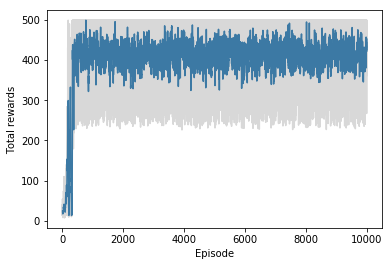

In [43]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

Text(0,0.5,'Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [25]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

with tf.Session() as sess:

    # Initialize/restore/load the trained model 
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):

        # Start a new episode/epoch
        env.reset()
        
        # number of env/rob steps
        for _ in range(test_max_steps):
            
            # Rendering the env graphics
            env.render()
            
            # Batch from the OLD memory
            batch = memory.buffer
            #actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            
            # Calculating next action using OLD memory
            feed_dict={model.states: states}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            last_action_logits = actions_logits[-1]
            
            # Take action, get new state and reward
            #action = env.action_space.sample()
            action = np.argmax(last_action_logits)
            state, _, done, _ = env.step(action)
            reward = 1 - float(done)
            
            # New memory (time direction)
            memory.buffer.append((action, state, reward))
            
            # The task is done or not;
            if done:
                break
                
# Closing the env
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.